In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [ ]:
products_path = 'data/amazon_products.csv'
categories_path = 'data/amazon_categories.csv'

products = pd.read_csv(products_path)
categories = pd.read_csv(categories_path)

merged_data = pd.merge(products, categories, left_on='category_id', right_on='id')


In [ ]:
merged_data['DiscountRate'] = (merged_data['listPrice'] - merged_data['price']) / merged_data['listPrice']
merged_data['DiscountRate'] = merged_data['DiscountRate'].fillna(0).clip(lower=0)

merged_data = merged_data[['title', 'imgUrl', 'price', 'listPrice', 'DiscountRate', 'stars', 'reviews', 'boughtInLastMonth', 'category_name']]

In [ ]:
keywords = [
    'christmas', 'noel', 'xmas', 'santa', 'reindeer', 'snowman', 'nativity', 
    'mistletoe', 'gingerbread', 'yule', 'winter', 'festive', 'holiday', 
    'ornament', 'stocking', 'elf', 'carol', 'candy cane', 'north pole', 
    'sleigh', 'christmas tree', 'wreath', 'jingle bells', 'advent', 'angel', 
    'star', 'snowflake', 'fireplace', 'hot cocoa', 'peppermint', 'celebration', 
    'gift', 'present', 'decor', 'lights', 'family', 'joy', 'peace', 'love', 'cheer'
]

merged_data['title_lower'] = merged_data['title'].astype(str).str.lower()

merged_data = merged_data[merged_data['title_lower'].apply(lambda x: any(keyword in x for keyword in keywords))]

merged_data.dropna(inplace=True)

encoder = LabelEncoder()
merged_data['category_encoded'] = encoder.fit_transform(merged_data['category_name'])

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(merged_data[['price', 'listPrice', 'DiscountRate', 'stars', 'reviews', 'boughtInLastMonth', 'category_encoded']])


In [ ]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

window_size = 10
X, y = create_sequences(scaled_features, window_size)

split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [ ]:
model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))


C:\Users\salah\Desktop\EventRecommendationSystem\flask-api\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 68s 38ms/step - loss: 6.8603e-05 - val_loss: 2.7103e-05
Epoch 2/10
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 80s 37ms/step - loss: 3.4161e-05 - val_loss: 2.6832e-05
Epoch 3/10
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 75s 32ms/step - loss: 3.5046e-05 - val_loss: 2.6534e-05
Epoch 4/10
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 53s 32ms/step - loss: 3.3874e-05 - val_loss: 2.6429e-05
Epoch 5/10
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 53s 32ms/step - loss: 3.4723e-05 - val_loss: 2.6924e-05
Epoch 6/10
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 54s 33ms/step - loss: 3.9151e-05 - val_loss: 2.5290e-05
Epoch 7/10
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 81s 33ms/step - loss: 4.2305e-05 - val_loss: 2.5373e-05
Epoch 8/10
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 54s 33ms/step - loss: 2.8824e-05 - val_loss: 2.5494e-05
Epoch 9/10
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 54s 33ms/step - loss: 3.2520e-05 - val_loss: 2.5745e-05
Epoch 10/10
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 54s 33ms/step - loss: 3.6108e-05 - val_loss: 2.5368e-05


In [ ]:
os.makedirs('models', exist_ok=True)
model.save('predictions/noel/noel_model.h5')

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate([predictions, np.zeros((len(predictions), 6))], axis=1))[:, 0]

1630/1630 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step


In [ ]:
titles = merged_data['title'].values[-len(predictions):]
img_urls = merged_data['imgUrl'].values[-len(predictions):]
price_old = merged_data['listPrice'].values[-len(predictions):]
discount_rates = merged_data['DiscountRate'].values[-len(predictions):]

result_df = pd.DataFrame({
    'Title': titles,
    'Image URL': img_urls,
    'Old Price': price_old,
    'Discount Rate': discount_rates,
    'Predicted Price': predictions
})

result_df['Effective Discount'] = result_df['Old Price'] - result_df['Predicted Price']

result_df = result_df.sort_values(by='Effective Discount', ascending=False).head(100000)

os.makedirs('predictions', exist_ok=True)
result_df.to_csv('predictions/noel/noel_predictions.csv', index=False)

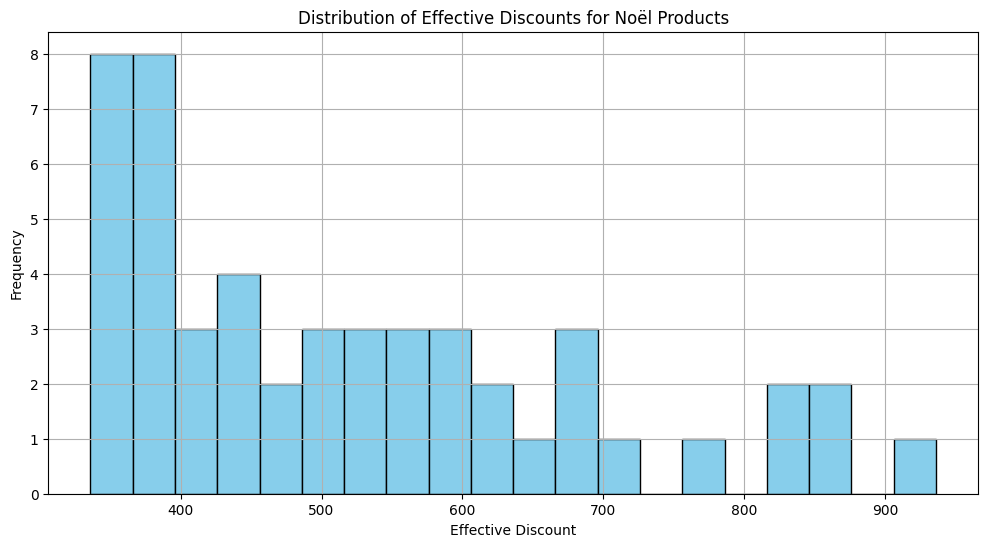

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(result_df['Effective Discount'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Effective Discounts for Noël Products')
plt.xlabel('Effective Discount')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


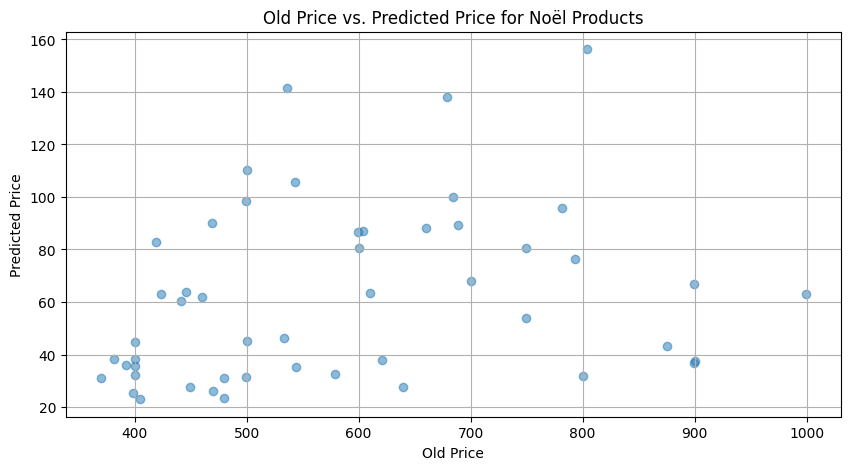

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(result_df['Old Price'], result_df['Predicted Price'], alpha=0.5)
plt.title('Old Price vs. Predicted Price for Noël Products')
plt.xlabel('Old Price')
plt.ylabel('Predicted Price')
plt.grid(True)
plt.show()